In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np


# Loading data and initial exploration

In [2]:
df_users = pd.read_csv('takehome_users.csv')

print(df_users.shape)
df_users.head(3)

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
df_engage = pd.read_csv('takehome_user_engagement.csv')

print(df_engage.shape)
df_engage.head(3)

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 3:53,1,1
1,2013-11-15 3:45,2,1
2,2013-11-29 3:45,2,1


In [5]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'])

df_engage has perfect data (no null values), df_users will need to have some imputation.

# Data imputation

### last_session_creation_time

What do the null values for last_session_creation_time mean? That they never logged in?

In [7]:
user_no_login = df_users[df_users.last_session_creation_time.isnull()]['object_id'].to_list()
df_engage[df_engage.user_id.isin(user_no_login)]

,time_stamp,user_id,visited


Confirmed the null values for last_session_creation_time means that they have NEVER logged in. These clients clearly are not adopted users. 

This is good information so should not be thrown away, we can flag these as 'not adopted'. We will end up dropping the time stamp counts and converting so not imputing this data will not harm the interpretation.

In [8]:
def not_adopted_session(df):
    if df.last_session_creation_time is None:
        df['adopted_user'] = False
    
    return df

df_users = df_users.apply(not_adopted_session,axis=1)

### invited_by_user_id

What do null values mean here? That they weren't invited by anyone? Are individual id's really useful - is it more important to know if they were invited or not invited?

Let's find out if there are any patterns or strong inviters - if not then we can probably change this into a binary feature : invited or not invited.

In [9]:
df_users.invited_by_user_id.value_counts()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
           ..
2746.0      1
10456.0     1
8371.0      1
6266.0      1
3572.0      1
Name: invited_by_user_id, Length: 2564, dtype: int64

Max counted user has only 13 invites, this won't be useful data if we try to interpret this by individual user id's.

Let's create a new feature 'invited_by_user' and have 0 denote not invited, and 1 denote invited.

In [10]:
df_users['invited_by_user_id'].fillna(0,inplace=True)

def invited_user(df):
    if df.invited_by_user_id == 0:
        df['invited_by_user'] = False
    else:
        df['invited_by_user'] = True
    
    return df

df_users = df_users.apply(invited_user,axis=1)

df_users = df_users.drop(['invited_by_user_id'],axis=1)

df_users.invited_by_user.value_counts()

True     6417
False    5583
Name: invited_by_user, dtype: int64

### How to define adopted_user

Adopted_user:
If user has logged into the product three separate days in at least one seven day period

Are the last_session_creation_time stamps in df_engage?

In [11]:
#Convert unix to datetime : 
print(datetime.utcfromtimestamp(df_users.last_session_creation_time[0]).strftime('%Y-%m-%d %H:%M:%S'))

print(df_engage[df_engage.user_id == df_users.object_id[0]].time_stamp.values[0])

2014-04-22 03:53:30
2014-04-22T03:53:00.000000000


Looks like yes. We'll proceed as if this is true for all members.

In [12]:
groupby_sum = df_engage.set_index('time_stamp').sort_index().groupby('user_id').rolling('7d')['visited'].sum()

list_adopted = groupby_sum[groupby_sum>=3].reset_index()['user_id'].unique().tolist()

In [13]:
for id in list_adopted:
    df_users.loc[df_users[df_users.object_id == id].index.values[0],'adopted_user'] = True
    
df_users['adopted_user'].fillna(False,inplace=True)

df_users.adopted_user.value_counts()

False    10398
True      1602
Name: adopted_user, dtype: int64

# Data Processing and EDA

Easiest way to find the important features is to use a pearson's correlation table or heatmap. Before we can use this with our categorical features, we need to one hot encode the variables.

In [14]:
df_users.drop(['object_id','creation_time','name','email','last_session_creation_time'],
              axis=1,inplace=True)

df_users[['opted_in_to_mailing_list','enabled_for_marketing_drip']] = df_users[['opted_in_to_mailing_list','enabled_for_marketing_drip']].astype('bool') 

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   creation_source             12000 non-null  object
 1   opted_in_to_mailing_list    12000 non-null  bool  
 2   enabled_for_marketing_drip  12000 non-null  bool  
 3   org_id                      12000 non-null  int64 
 4   invited_by_user             12000 non-null  bool  
 5   adopted_user                12000 non-null  bool  
dtypes: bool(4), int64(1), object(1)
memory usage: 234.5+ KB


In [15]:
var = 'creation_source'
df_users = pd.concat([df_users,pd.get_dummies(df_users[var],prefix=var)],axis=1)

df_users.drop(labels=[var],axis=1,inplace=True)

In [16]:
var = 'opted_in_to_mailing_list'
df_users = pd.concat([df_users,pd.get_dummies(df_users[var],prefix=var)],axis=1)

df_users.drop(labels=[var],axis=1,inplace=True)

In [17]:
var = 'enabled_for_marketing_drip'
df_users = pd.concat([df_users,pd.get_dummies(df_users[var],prefix=var)],axis=1)

df_users.drop(labels=[var],axis=1,inplace=True)

In [18]:
var = 'invited_by_user'
df_users = pd.concat([df_users,pd.get_dummies(df_users[var],prefix=var)],axis=1)

df_users.drop(labels=[var],axis=1,inplace=True)

In [19]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   org_id                              12000 non-null  int64
 1   adopted_user                        12000 non-null  bool 
 2   creation_source_GUEST_INVITE        12000 non-null  uint8
 3   creation_source_ORG_INVITE          12000 non-null  uint8
 4   creation_source_PERSONAL_PROJECTS   12000 non-null  uint8
 5   creation_source_SIGNUP              12000 non-null  uint8
 6   creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8
 7   opted_in_to_mailing_list_False      12000 non-null  uint8
 8   opted_in_to_mailing_list_True       12000 non-null  uint8
 9   enabled_for_marketing_drip_False    12000 non-null  uint8
 10  enabled_for_marketing_drip_True     12000 non-null  uint8
 11  invited_by_user_False               12000 non-null  uint8
 12  invi

org_id                                0.064523
adopted_user                          1.000000
creation_source_GUEST_INVITE          0.045408
creation_source_ORG_INVITE           -0.007636
creation_source_PERSONAL_PROJECTS    -0.075817
creation_source_SIGNUP                0.009299
creation_source_SIGNUP_GOOGLE_AUTH    0.036119
opted_in_to_mailing_list_False       -0.008097
opted_in_to_mailing_list_True         0.008097
enabled_for_marketing_drip_False     -0.004653
enabled_for_marketing_drip_True       0.004653
invited_by_user_False                -0.027671
invited_by_user_True                  0.027671
Name: adopted_user, dtype: float64


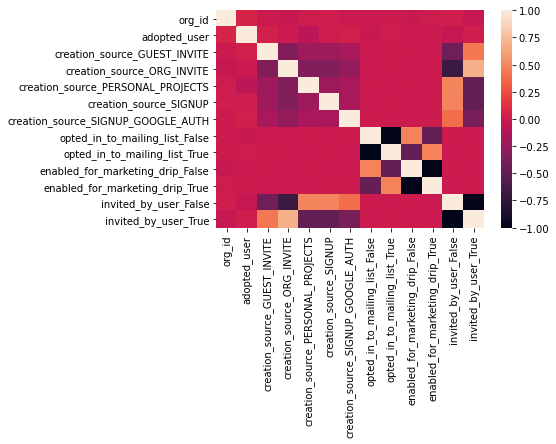

In [20]:
corr = df_users.corr(method='pearson')
print(corr['adopted_user'])
sns.heatmap(corr)

So far looks like there are no major factors that show significant impact on the adopted_user status. Personal projects being a creation source show the strongest impact to not being an adopted user, while guest invites and google_auth signups show stronger impacts of being adopted users. org_id also shows a significant impact on the adopted_user status however, it is harder to interpret due to the large amount of labels in the feature. Let's see if we can dig into it a bit more.

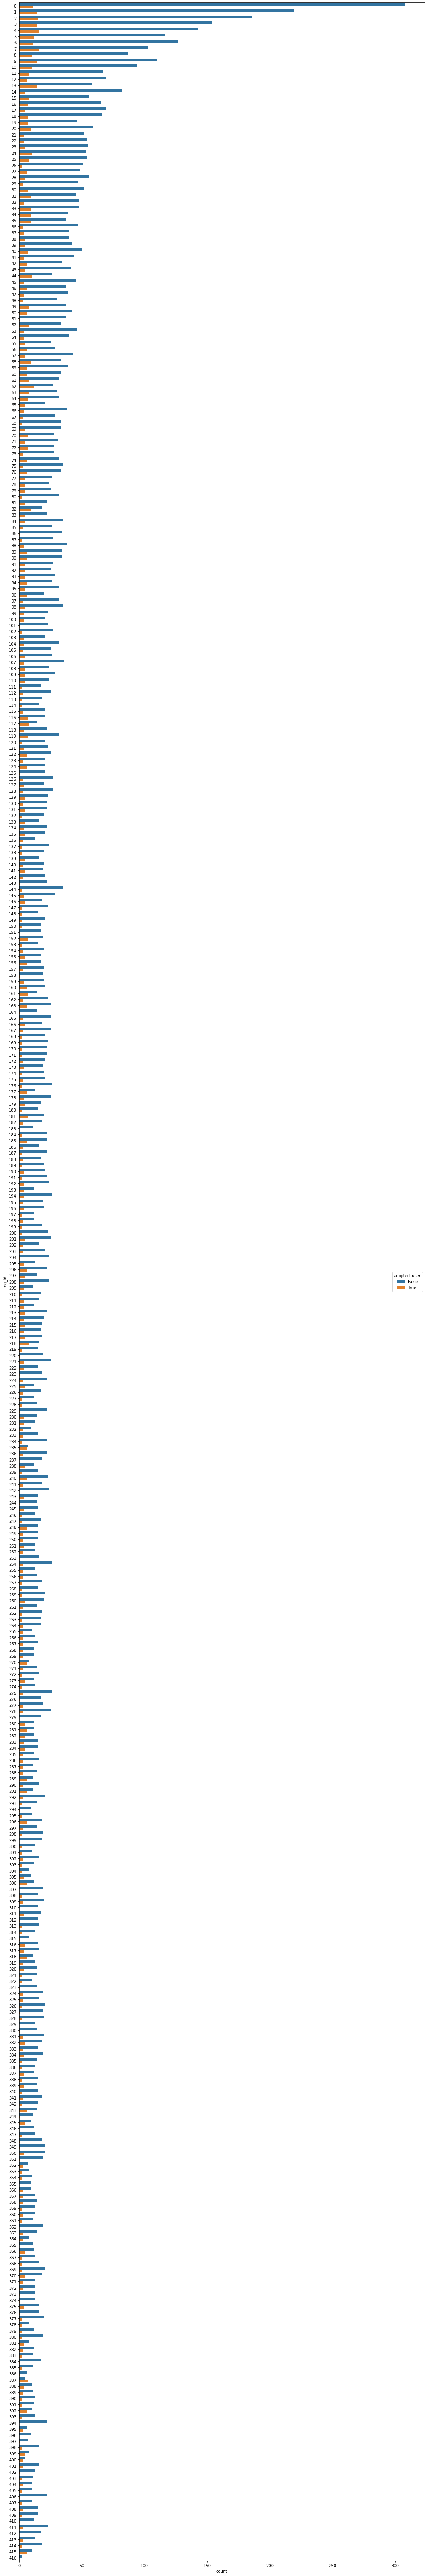

In [21]:
plt.figure(figsize=(15,90))

sns.countplot(data = df_users, y='org_id',hue='adopted_user')

plt.tight_layout()

Looks like some individual organistaions have higher percentage impact, but nothing too telling. No org has a higher amount of adopted users than non-adopted users.

In [22]:
var = 'org_id'
df_users = pd.concat([df_users,pd.get_dummies(df_users[var],prefix=var)],axis=1)

df_users.drop(labels=[var],axis=1,inplace=True)

In [23]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import (plot_confusion_matrix, classification_report)

from imblearn.over_sampling import SMOTE

In [25]:
X = df_users.drop(['adopted_user'],axis=1)
y = df_users['adopted_user']

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [26]:
model = RandomForestClassifier(random_state=42)

feat_sel = SelectKBest()

grid_params = {
    'feat_sel__k': ['all'],
}

RFC_base = GridSearchCV(Pipeline([('feat_sel',feat_sel),('model',model)]),cv=5,param_grid=grid_params,n_jobs=-1)

RFC_base.fit(X_train,y_train)

y_pred = RFC_base.predict(X_test)

              precision    recall  f1-score   support

       False       0.96      0.87      0.91      2860
        True       0.06      0.18      0.09       140

    accuracy                           0.83      3000
   macro avg       0.51      0.52      0.50      3000
weighted avg       0.91      0.83      0.87      3000



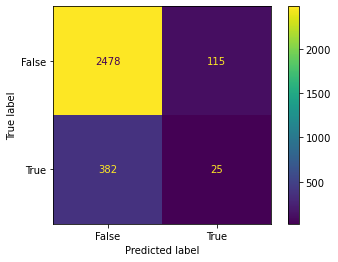

In [27]:
print(classification_report(y_pred,y_test))
plot_confusion_matrix(RFC_base,X_test,y_test)

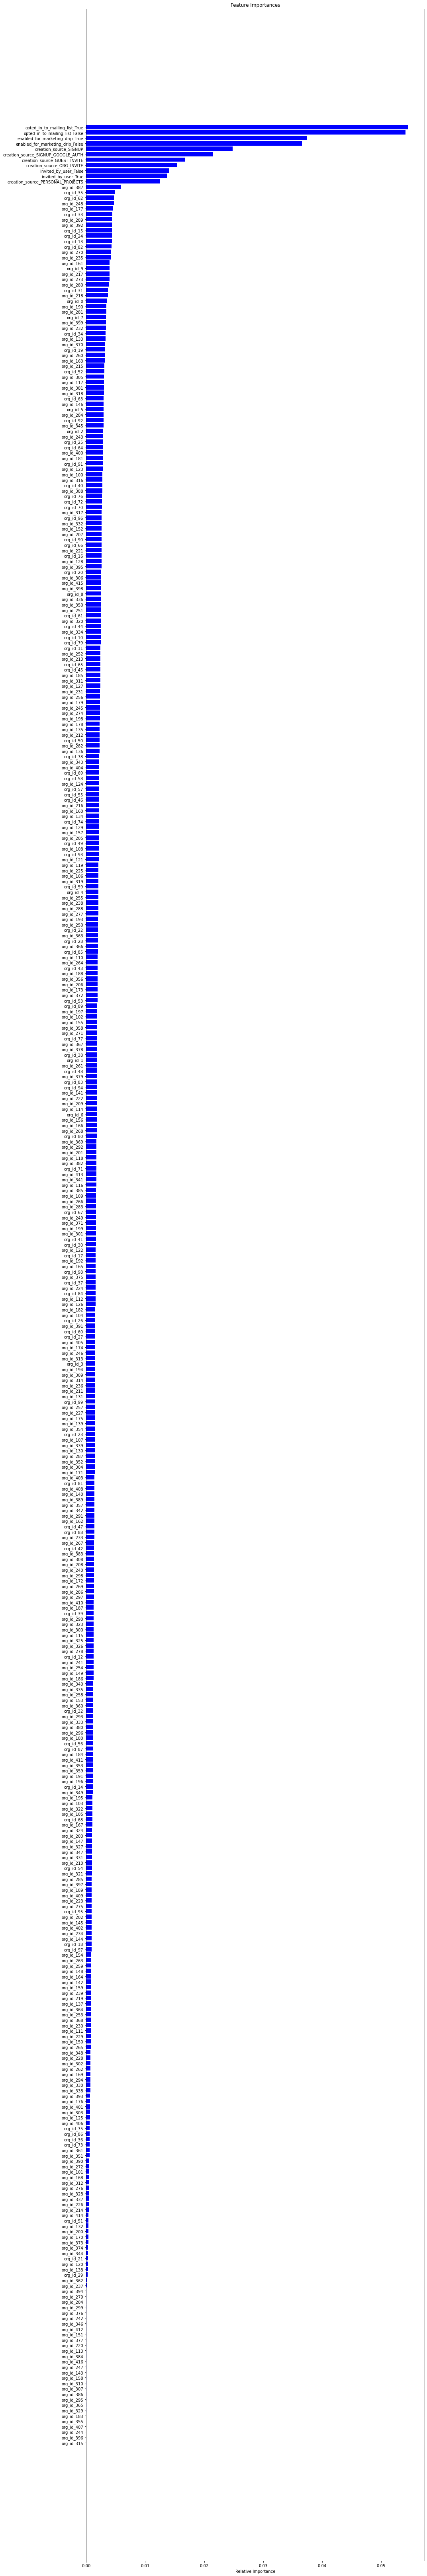

In [29]:
features = X.columns.tolist()
importances = RFC_base.best_estimator_.named_steps.model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,90))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()